In [1]:
import numpy as np
import pandas as pd
import time

import extra_data as ed
from skimage.feature import peak_local_max

import cv2
import tifffile as tif

from skimage.transform import rescale, rotate

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares, minimize_scalar

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.style.use('/home/adescamp/newClassic.mplstyle')

%config InlineBackend.figure_format='retina'


Bad key "mathtext.fallback" on line 160 in
/home/adescamp/newClassic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titley" on line 181 in
/home/adescamp/newClassic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "date.converter" on line 237 in
/home/adescamp/newClassic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "figure.labelsize" on line 312 in
/home/adescamp/newClassic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source

## Load calibration

In [17]:
exp_id = 900499 # Commisioning experiment
run_id = 78 # Streak camera calibration image run

# Import run data and display info on run
run = ed.open_run(exp_id, run_id)

# Determine first and last train ids
first_train = run.train_ids[0]
last_train = run.train_ids[-1]
print(f'First train ID: {first_train}')
print(f'Last train ID: {last_train}')

# Create a mask for pandas df where no data exists
mask = run['HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput', 'data.image.pixels'].data_counts() != 0

# Create array for train IDs where data exists
indexes = mask.to_numpy().nonzero()+first_train
indexes_count = indexes.shape[1]
# Total number of trains with data
print(f'{indexes_count} Train IDs with data present:\n{indexes}')

# # Select train ID for streak calibration
# train_id = 1605832127
# print(f'\nSelecting Train ID: {train_id}')

# Raw data from streak camera image
kep2 = run['HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput']['data.image.pixels'].select_trains(ed.by_id[np.squeeze(indexes)]).ndarray()

img = np.mean(kep2, axis = 0).copy()
# img = np.copy(kep2[1, :, :])

# Rotate image 90 degrees
img = rotate(img, 90, preserve_range=True)

First train ID: 2300271603
Last train ID: 2300272203
30 Train IDs with data present:
[[2300271604 2300271624 2300271644 2300271664 2300271684 2300271704
  2300271724 2300271744 2300271764 2300271784 2300271804 2300271824
  2300271844 2300271864 2300271884 2300271904 2300271924 2300271944
  2300271964 2300271984 2300272004 2300272024 2300272044 2300272064
  2300272084 2300272104 2300272124 2300272144 2300272164 2300272184]]


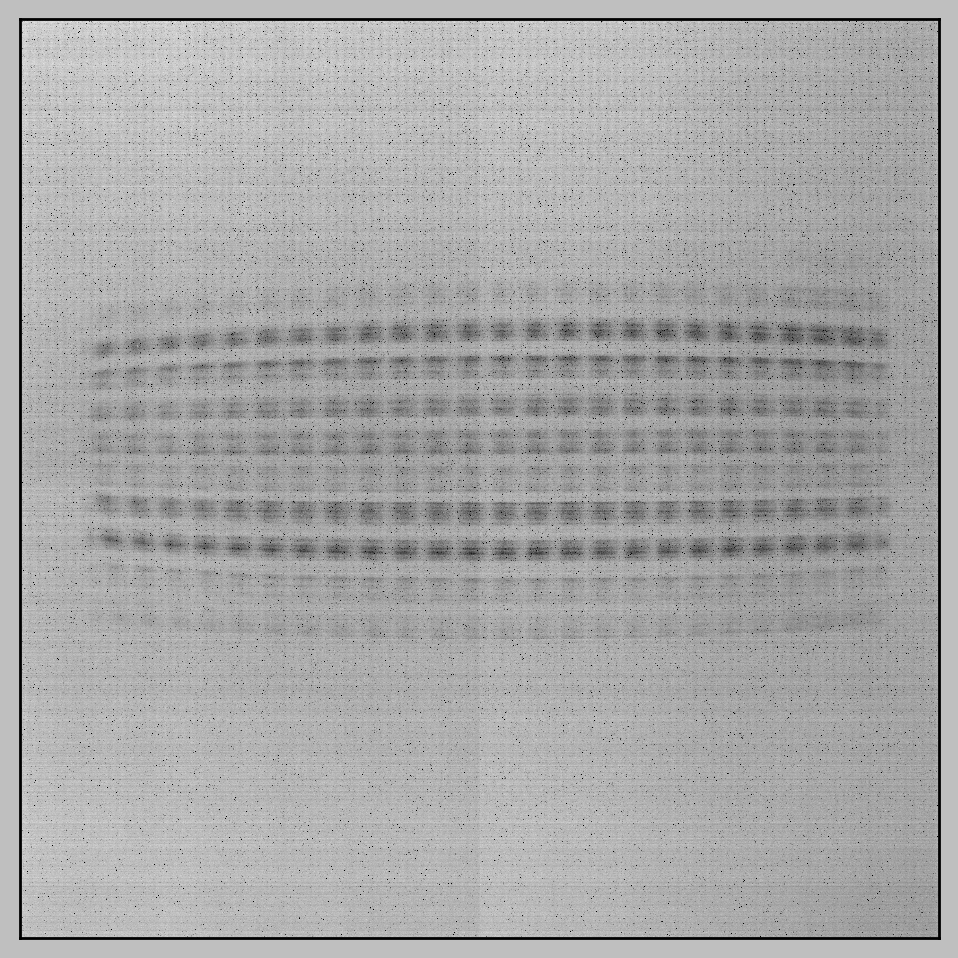

In [18]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(img, cmap = 'binary', vmin = 100, vmax = 200)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig('../Im_r1222_V2.png', dpi = 400)
plt.show()

## Using calibration from the image

In [118]:
img_filter = gaussian_filter(img, (20, 15))

In [221]:
peakPosition = peak_local_max(img_filter[550:3450, 300:3650], min_distance=50, threshold_abs=110)

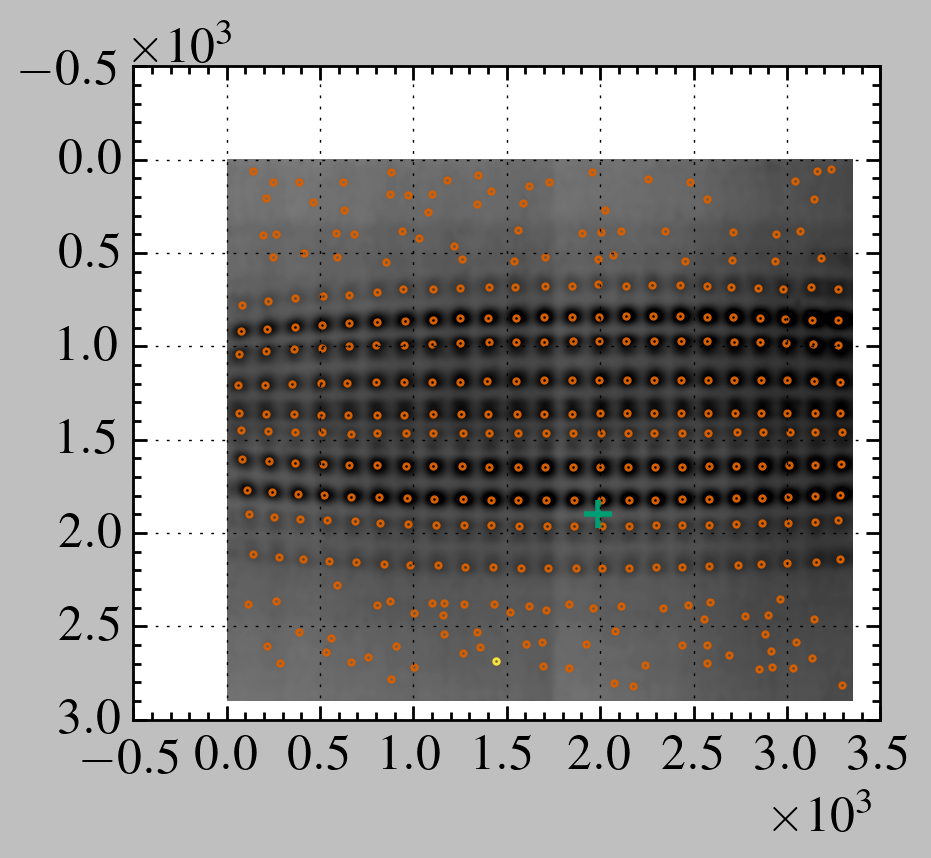

In [222]:
plt.figure(figsize = (5, 5))
# plt.subplot(221)
# plt.imshow(imgKEP1_20nsCalib_20nsSweep_2024-imgKEP1_bckg, vmin = 0, vmax = 100, cmap = plt.cm.jet)

plt.subplot(111)
plt.imshow(img_filter[550:3450, 300:3650], vmin = 100, vmax = 150, cmap = plt.cm.binary)
# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
plt.plot(peakPosition[:, 1], peakPosition[:, 0], '.C2', ms = 2)
idx = 14
plt.plot(peakPosition[idx, 1], peakPosition[idx, 0], '.C4', ms = 2)
# plt.plot(peakPosition[14:32, 1], peakPosition[14:32, 0], '.C4', ms = 2)

plt.plot(1991, 1900, '+C1')
# plt.colorbar()
plt.tight_layout()
plt.show()

In [223]:
peakPosition = np.delete(peakPosition, np.where(peakPosition[:, 0]>2200), axis = 0)
peakPosition = np.delete(peakPosition, np.where(peakPosition[:, 0]<600), axis = 0)
# peakPosition = np.delete(peakPosition, [212, 213], axis = 0)
# peakPosition = np.delete(peakPosition, np.arange(92, 104), axis = 0)

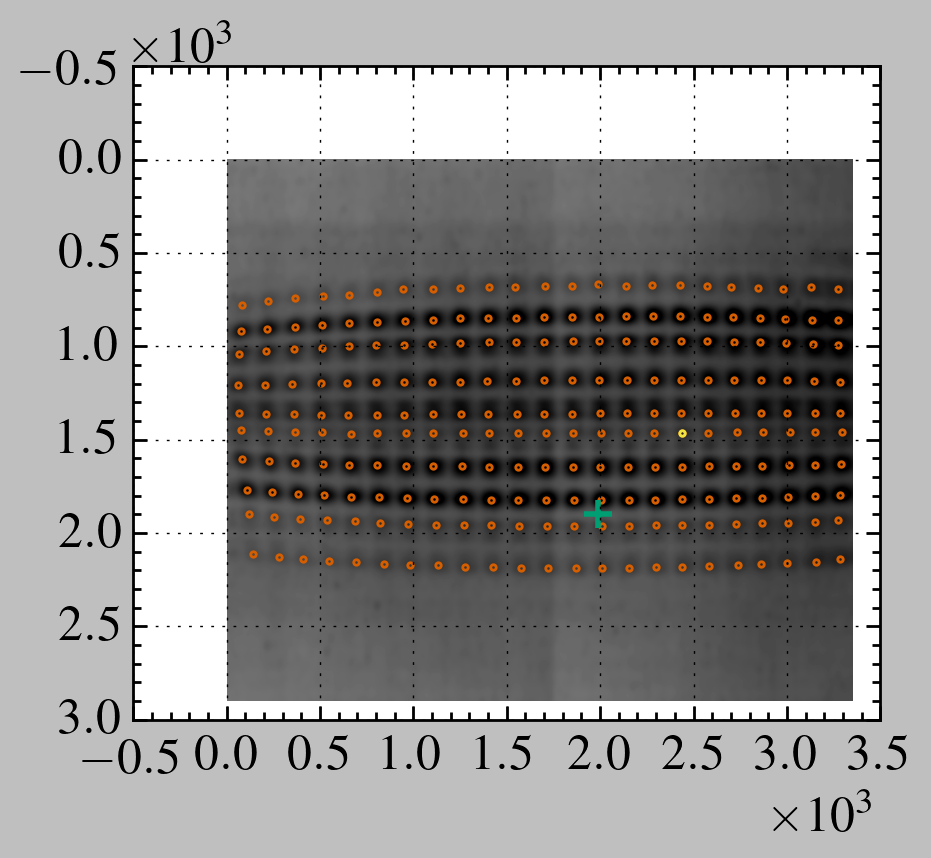

In [224]:
plt.figure(figsize = (5, 5))
# plt.subplot(221)
# plt.imshow(imgKEP1_20nsCalib_20nsSweep_2024-imgKEP1_bckg, vmin = 0, vmax = 100, cmap = plt.cm.jet)

plt.subplot(111)
plt.imshow(img_filter[550:3450, 300:3650], vmin = 100, vmax = 150, cmap = plt.cm.binary)
# plt.hlines(3000, 0, 4095, color = 'w')
# plt.hlines(3200, 0, 4095, color = 'w')
plt.plot(peakPosition[:, 1], peakPosition[:, 0], '.C2', ms = 2)
idx = 105
plt.plot(peakPosition[idx, 1], peakPosition[idx, 0], '.C4', ms = 2)
# plt.plot(peakPosition[14:32, 1], peakPosition[14:32, 0], '.C4', ms = 2)

plt.plot(1991, 1900, '+C1')
# plt.colorbar()
plt.tight_layout()
plt.show()

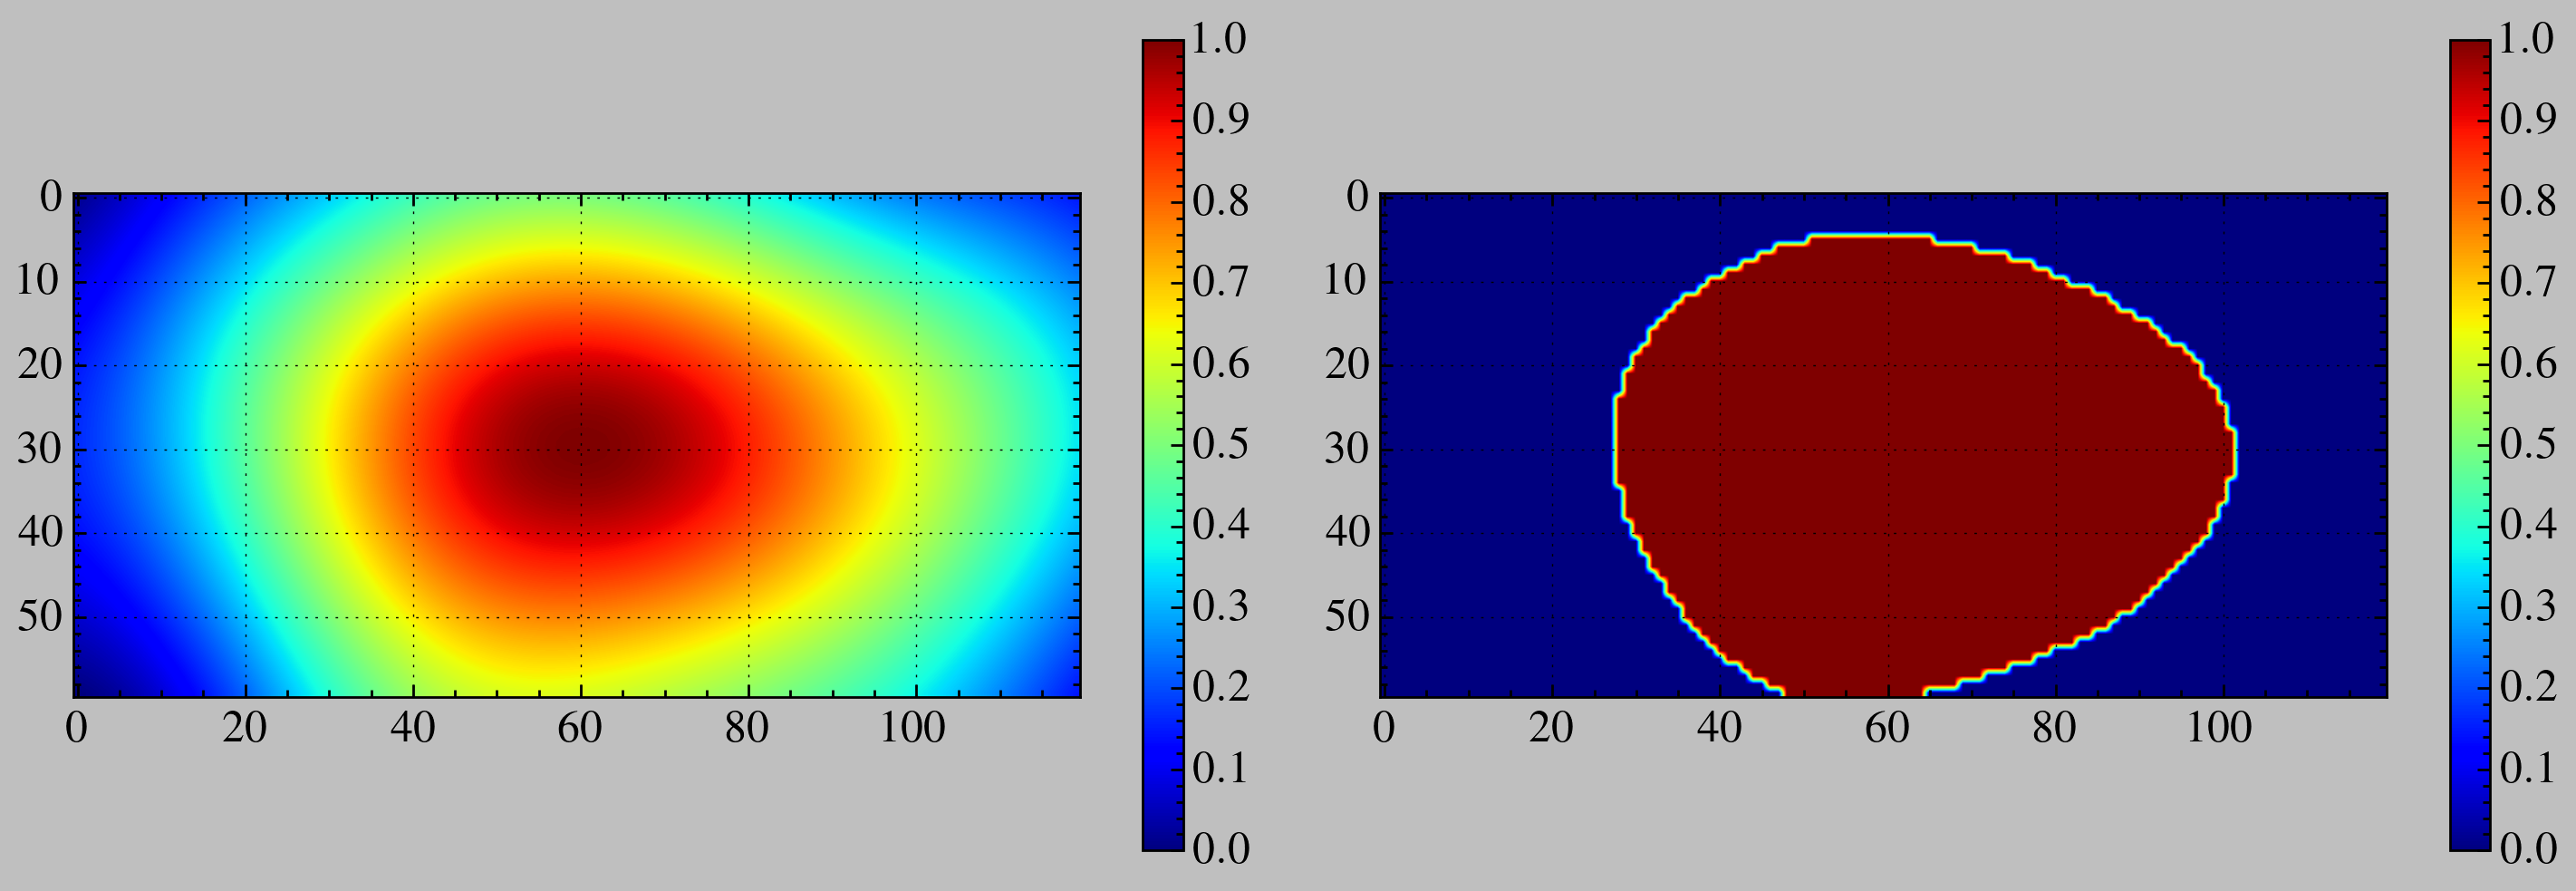

In [225]:
idx = 105
subImage = img_filter[550 + peakPosition[idx, 0] - 30:550 + peakPosition[idx, 0] + 30, 300 + peakPosition[idx, 1] - 60:300 + peakPosition[idx, 1] + 60]
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow((subImage-np.min(subImage))/(np.max(subImage)-np.min(subImage)))
plt.colorbar()

plt.subplot(222)
subImage_filter = np.zeros_like(subImage)
subImage_filter[(subImage-np.min(subImage))/(np.max(subImage)-np.min(subImage))>0.6] = 1
plt.imshow(subImage_filter)
plt.colorbar()

plt.tight_layout()
plt.show()

In [226]:
peakPositionInitialGuess = np.copy(peakPosition)

In [227]:
## Get the area aorund each found peak
## Create a filter with all the value above 80% of the maximum intensity
## Calculate the centre of mass of this filter in both direction
## This helps finding the centre of the square shaped peaks

nIterations = 10
peakPosition = np.copy(peakPositionInitialGuess)

for n in range(nIterations):
    print('Iteration #%.0f'%(n))
    peakPosition_refined = np.zeros_like(peakPosition)
    

    for i, idx in enumerate(range(0, peakPosition.shape[0])):
        X = np.arange(peakPosition[idx, 1] - 60, peakPosition[idx, 1] + 60)
        Y = np.arange(peakPosition[idx, 0] - 30, peakPosition[idx, 0] + 30)

        subImage = img_filter[550 + peakPosition[idx, 0] - 30:550 + peakPosition[idx, 0] + 30, 300 + peakPosition[idx, 1] - 60:300 + peakPosition[idx, 1] + 60]

        subImage_filter = np.zeros_like(subImage)
        subImage_filter[(subImage-np.min(subImage))/(np.max(subImage)-np.min(subImage))>0.6] = 1
        lineoutY = np.sum(subImage_filter, axis = 1)
        lineoutX = np.sum(subImage_filter, axis = 0)

        peakPosition_refined[idx, 0] = np.sum(Y * lineoutY)/np.sum(lineoutY)
        peakPosition_refined[idx, 1] = np.sum(X * lineoutX)/np.sum(lineoutX)
        
    peakPosition = np.copy(peakPosition_refined)

Iteration #0
Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
Iteration #8
Iteration #9


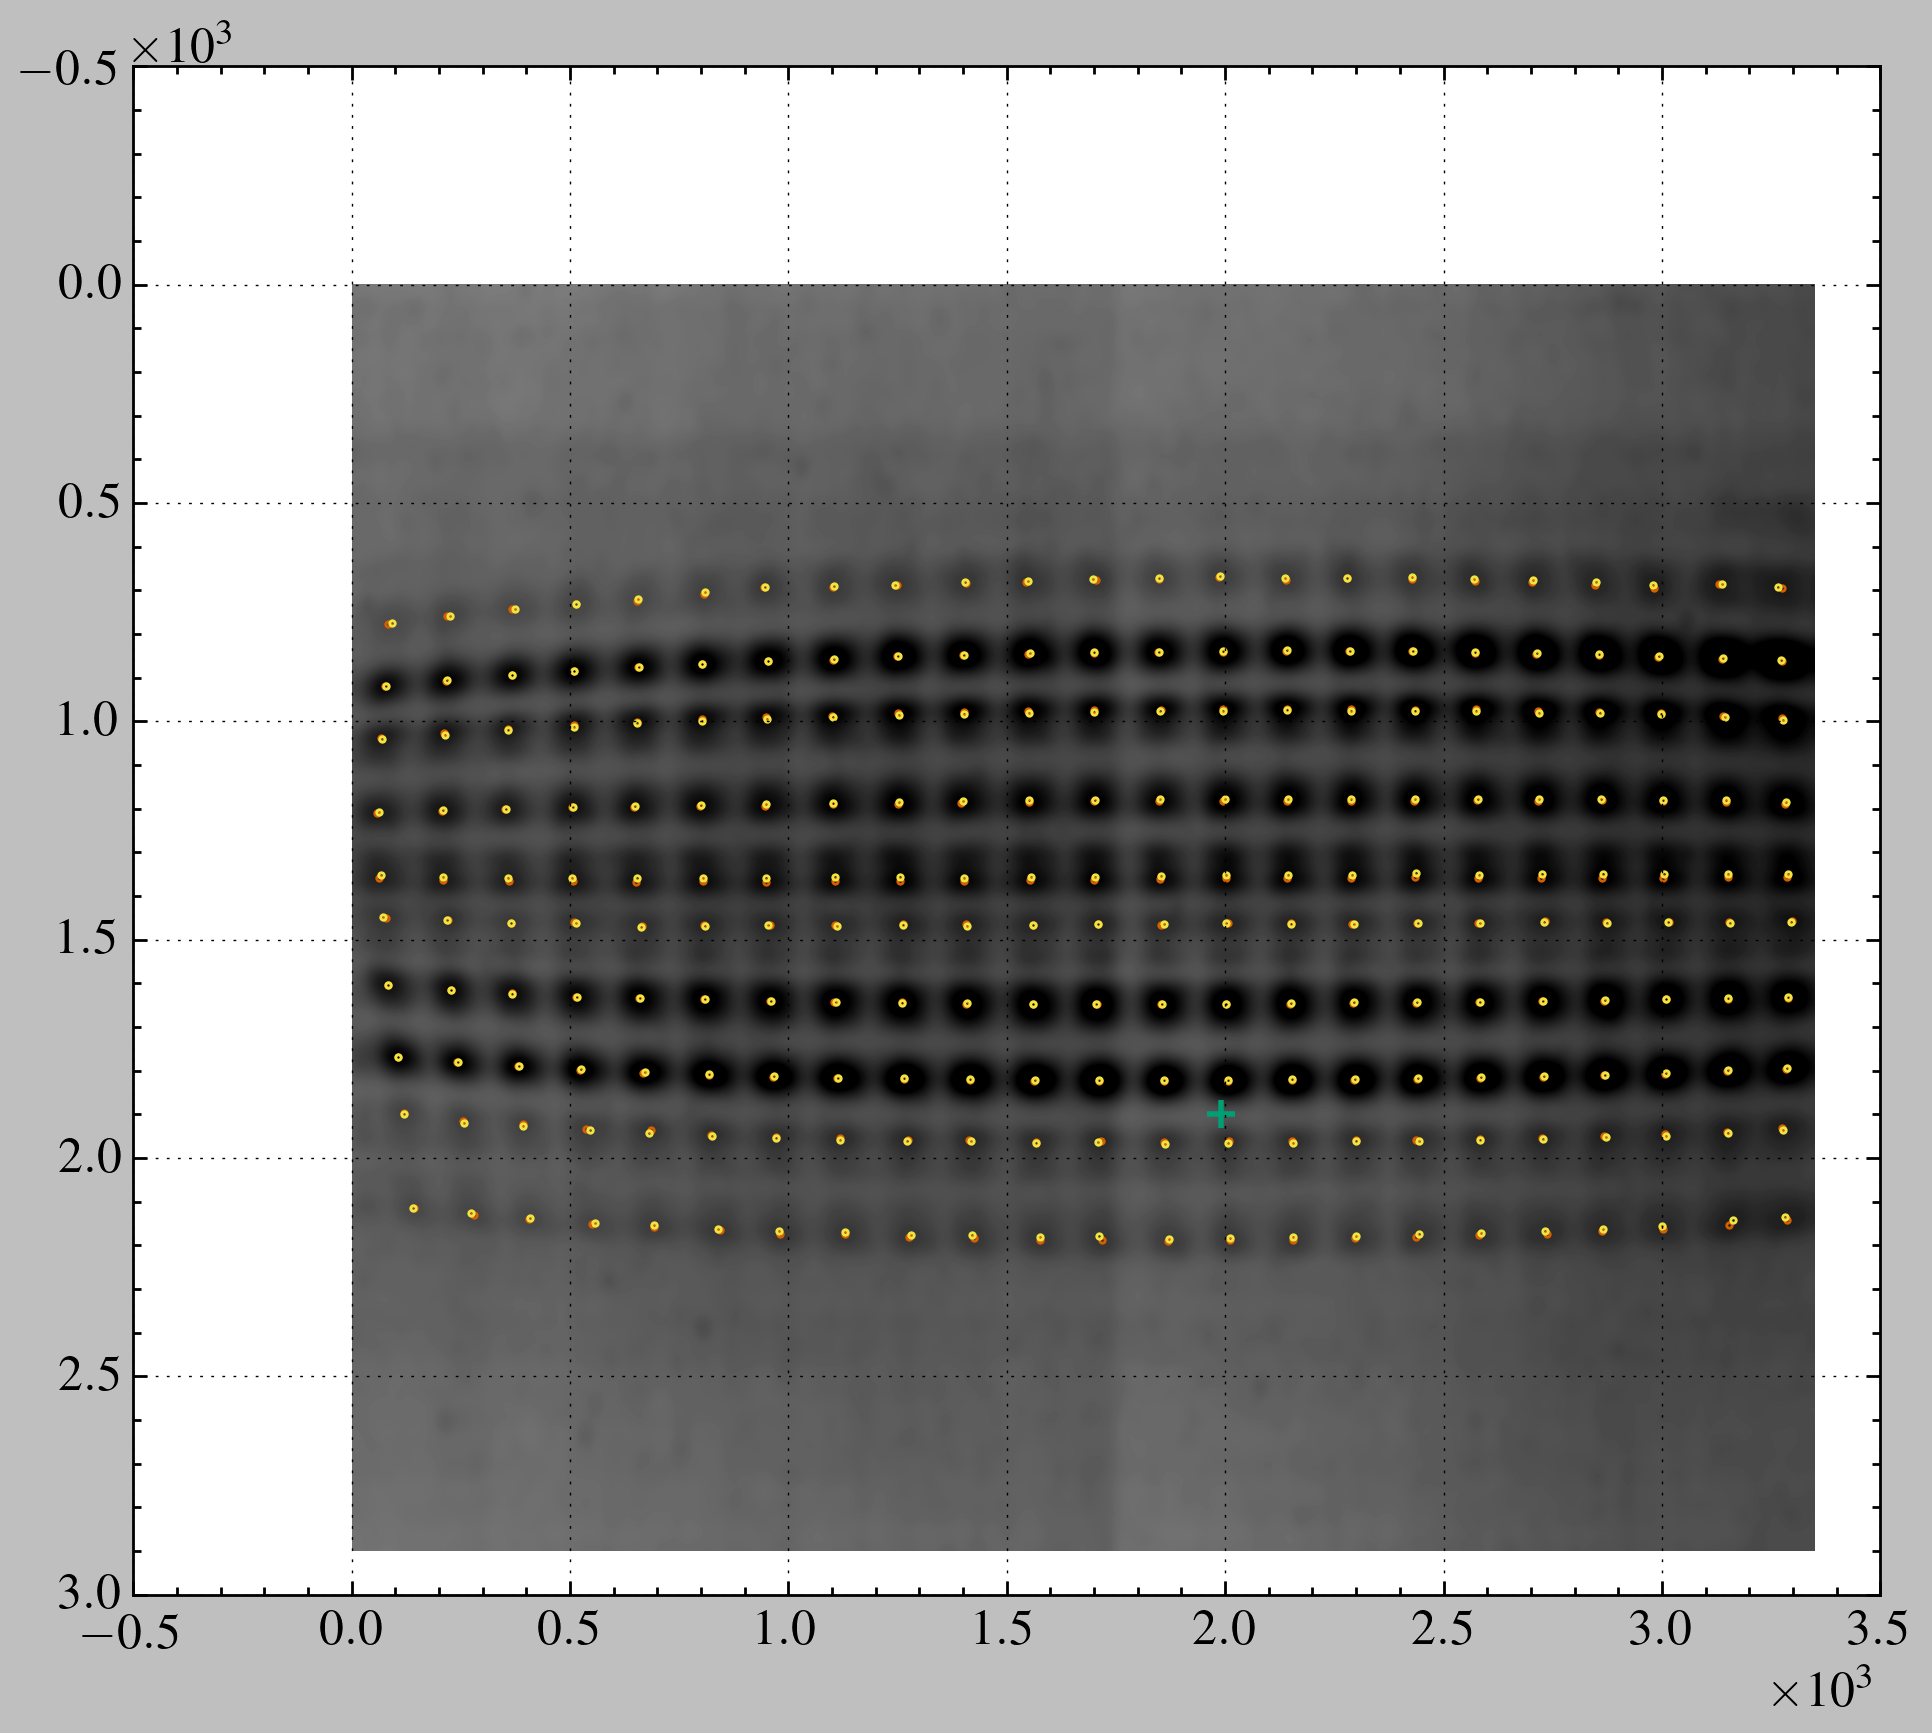

In [228]:
# Setup plot
plt.figure(figsize = (10, 10))
plt.subplot(111)
plt.imshow(img_filter[550:3450, 300:3650], vmin = 100, vmax = 150, cmap = plt.cm.binary)
# plt.colorbar()
plt.plot(peakPositionInitialGuess[:, 1], peakPositionInitialGuess[:, 0], '.C2', ms = 2)

plt.plot(peakPosition[:, 1], peakPosition[:, 0], '.C4', ms = 2)


# idx = 43
# plt.plot(peakPosition[idx, 1], peakPosition[idx, 0], '.C0', ms = 2)

plt.plot(1991, 1900, '+C1')

plt.tight_layout()
plt.show()

## Group peaks in the same line

In [229]:
numberRows = 9
numberColumns = 23

In [230]:
X_mesh = []
Y_mesh = []
for i in range(numberRows, -1, -1):
    print(i)
    X, Y = 300+peakPosition[i*numberColumns:(i+1)*numberColumns, 1], 550+peakPosition[i*numberColumns:(i+1)*numberColumns, 0]
    pos_sort = np.argsort(X)
    # print(X[pos_sort].shape)
    X_mesh += [X[pos_sort]]
    Y_mesh += [Y[pos_sort]]
    
X_mesh = np.array(X_mesh)
Y_mesh = np.array(Y_mesh)

9
8
7
6
5
4
3
2
1
0


In [231]:
X_mesh.shape

(10, 23)

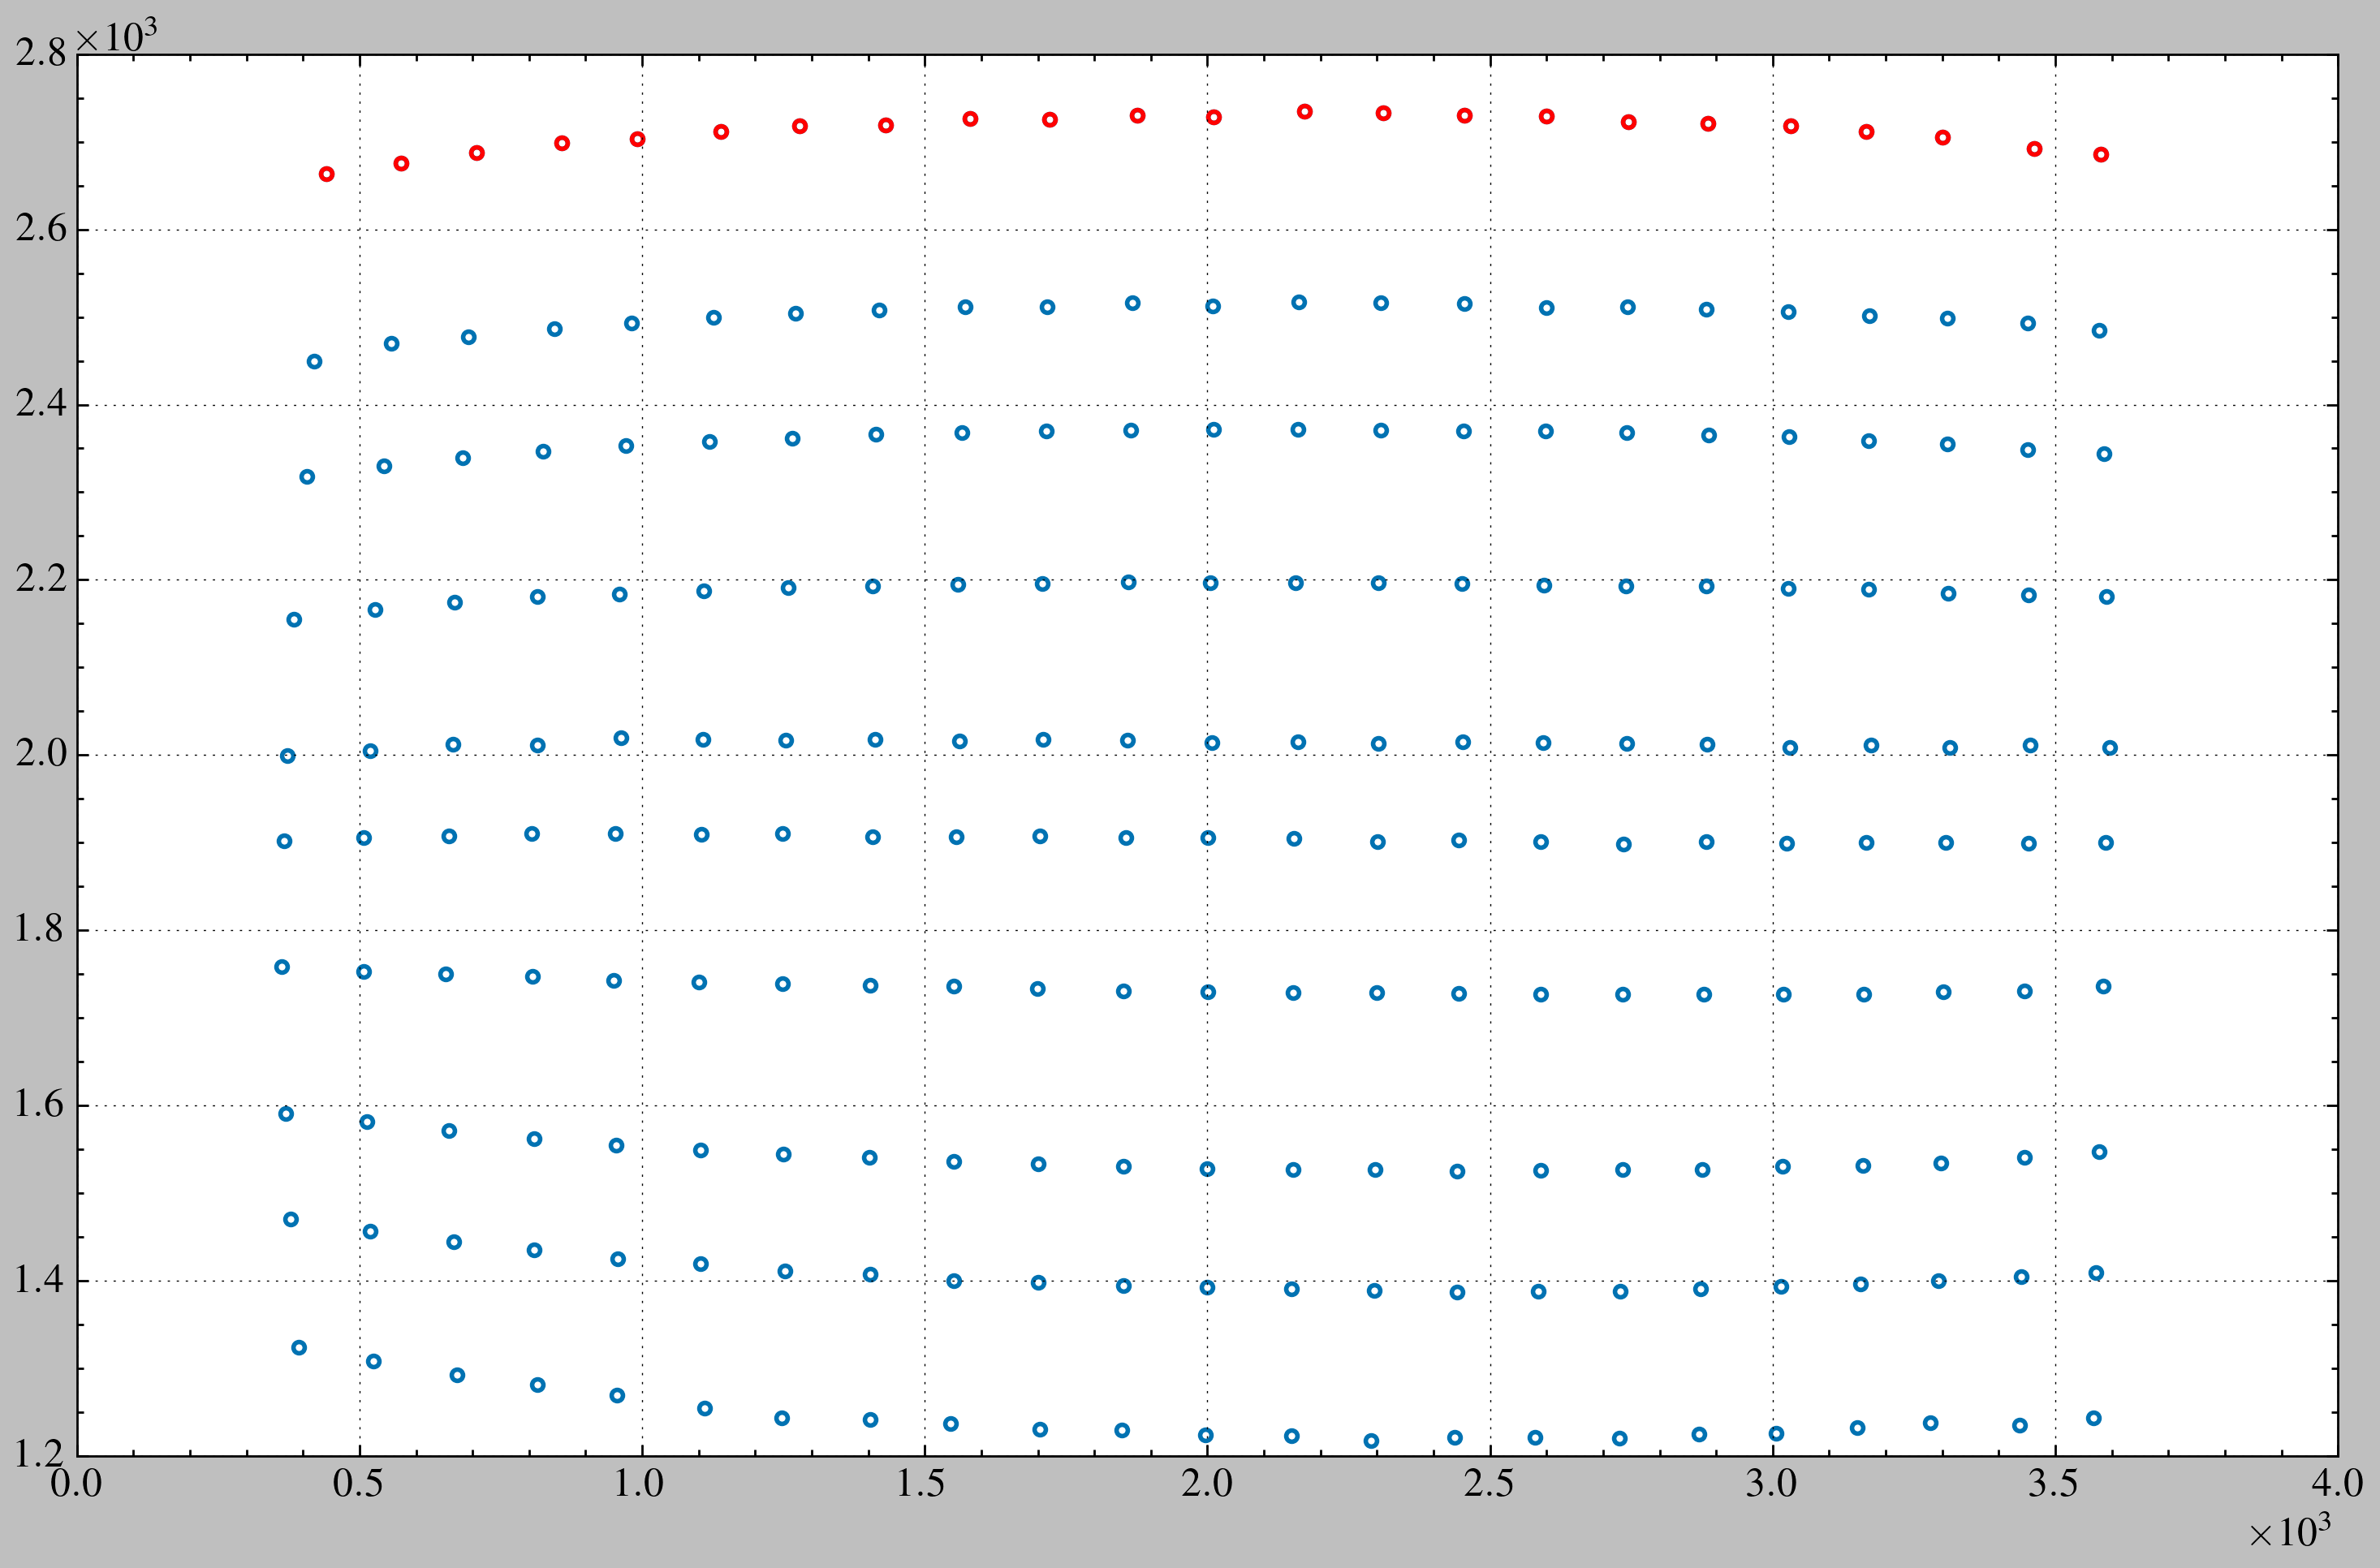

In [274]:
plt.plot(300+peakPosition[:, 1], 550+peakPosition[:, 0], '.')
# plt.plot(peakVectors[0, 45], peakVectors[1, 45], '.g')

# plt.plot(X_columns[1][:10], Y_columns[1][:10], '.r')
# plt.plot(X_rows[10], Y_rows[10], '.g')
plt.plot(X_mesh[9, :], Y_mesh[9, :], '.r')
# plt.plot(X_mesh[:, 2], Y_mesh[:, 2], '.r')
plt.show()

In [275]:

popt_column_sixth = []
residuals_column_sixth  = []
for i in range(X_mesh.shape[1]):
    popt_column_sixth += [np.polyfit(Y_mesh[:, i], X_mesh[:, i], 6, full = True)[0]]
    residuals_column_sixth += [np.polyfit(Y_mesh[:, i], X_mesh[:, i], 6, full = True)[1]]
    
popt_row_sixth = []
residuals_row_sixth  = []
for i in range(X_mesh.shape[0]):
    popt_row_sixth += [np.polyfit(X_mesh[i, :], Y_mesh[i, :], 6, full = True)[0]]
    residuals_row_sixth += [np.polyfit(X_mesh[i, :], Y_mesh[i, :], 6, full = True)[1]]
    

[-2.32057608e-18  2.68012799e-14 -1.19374390e-10  2.53263796e-07
 -2.28092440e-04 -2.15644787e-02  1.35449790e+03]


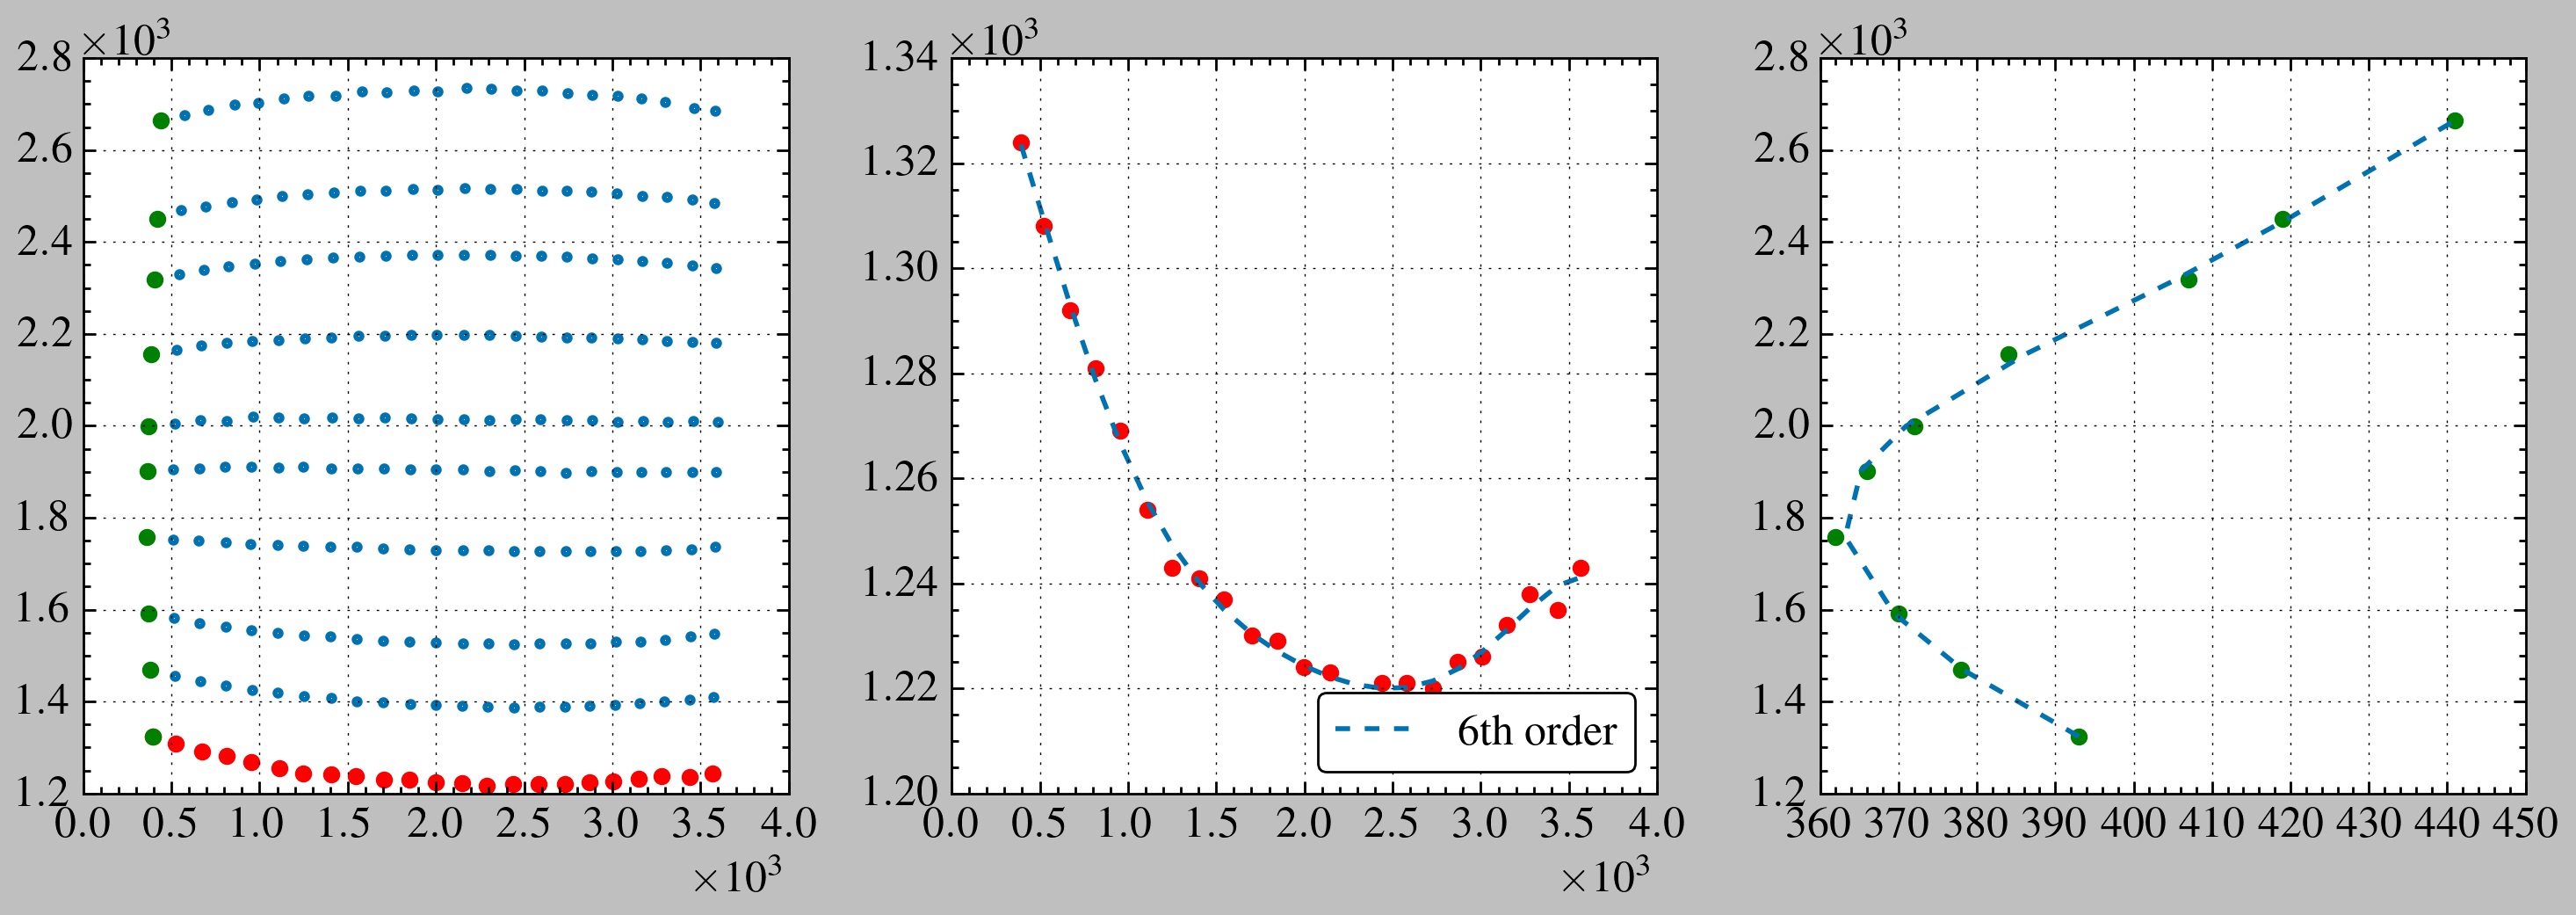

In [235]:
plt.figure(figsize = (15, 10))
plt.subplot(231)
plt.plot(300+peakPosition[:, 1], 550+peakPosition[:, 0], '.', ms = 5)
# plt.plot(peakVectors[0, 45], peakVectors[1, 45], '.g')

idxColumn = 0
idxRow = 0

plt.plot(X_mesh[idxColumn, :], Y_mesh[idxColumn, :], '.r', markerfacecolor = 'r')

plt.plot(X_mesh[:, idxRow], Y_mesh[:, idxRow], '.g', markerfacecolor = 'g')



plt.subplot(232)

plt.plot(X_mesh[idxRow, :], Y_mesh[idxRow, :], '.r', markerfacecolor = 'r')
print(popt_row_sixth[idxRow])
polySixth = np.poly1d(popt_row_sixth[idxRow])
plt.plot(X_mesh[idxRow, :], polySixth(X_mesh[idxRow, :]), '--', label = '6th order')


plt.legend(loc = 4)



plt.subplot(233)

plt.plot(X_mesh[:, idxColumn], Y_mesh[:, idxColumn], '.g', markerfacecolor = 'g')


polySixth = np.poly1d(popt_column_sixth[idxColumn])
plt.plot(polySixth(Y_mesh[:, idxColumn]), Y_mesh[:, idxColumn], '--')


plt.tight_layout()
# plt.savefig('../../../../EuXFEL-HED-VISAR-AnalysisRSI/ComparisonPolynomialCalibration.pdf')
plt.show()

In [276]:
def func(x, coeffLines, coeffColumns):
    a1, a2, a3, a4, a5, a6, a7 = coeffLines
    b1, b2, b3, b4, b5, b6, b7 = coeffColumns

    # print(coeffLines)
    
    interm = b1*x**6 + b2*x**5 + b3*x**4 + b4*x**3 + b5*x**2 + b6*x + b7 
    return np.abs(a1*interm**6 + a2*interm**5 + a3*interm**4 + a4*interm**3 + a5*interm**2 + a6*interm**1 + a7 - x)

In [277]:
original_grid_X_evt1_new = []
original_grid_Y_evt1_new = []

for i in range(len(popt_column_sixth)):
    b1, b2, b3, b4, b5, b6, b7 = popt_column_sixth[i]
    for ii in range(len(popt_row_sixth)):
        a1, a2, a3, a4, a5, a6, a7 = popt_row_sixth[ii]
        
        res = minimize_scalar(func, args = (popt_row_sixth[ii], popt_column_sixth[i]), method = 'Bounded', bounds = (1000, 3000))
        y = res.x
        x = b1*y**6 + b2*y**5 + b3*y**4 + b4*y**3 + b5*y**2 + b6*y + b7 
        original_grid_X_evt1_new += [x]
        original_grid_Y_evt1_new += [y]
        
original_grid_X_evt1_new = np.array(original_grid_X_evt1_new)
original_grid_Y_evt1_new = np.array(original_grid_Y_evt1_new)

In [278]:
len(popt_row_sixth)

10

[-1.91271211e-18  2.36817449e-14 -1.17945083e-10  3.03035500e-07
 -4.40426143e-04  3.76572258e-01  2.35175415e+03]
2514.874193134444


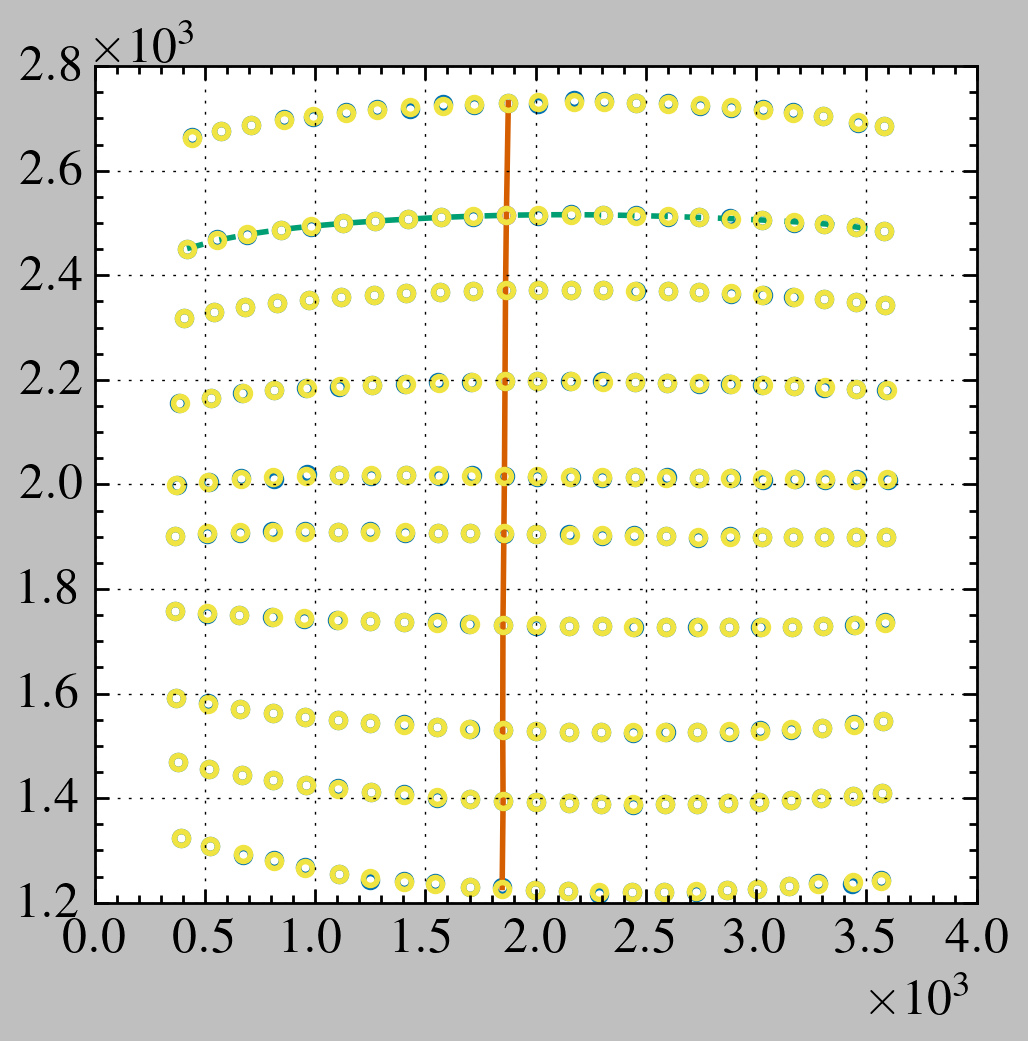

In [279]:
plt.figure(figsize = (15, 10))
plt.subplot(231)
plt.plot(300+peakPosition[:, 1], 550+peakPosition[:, 0], '.')

idxRow = 8
idxColumn = 10
polySixth_r = np.poly1d(popt_row_sixth[idxRow])
print(popt_row_sixth[idxRow])
plt.plot(X_mesh[idxRow, :], polySixth_r(X_mesh[idxRow, :]), '--', label = '6th order')

polySixth_c = np.poly1d(popt_column_sixth[idxColumn])
plt.plot(polySixth_c(Y_mesh[:, idxColumn]), Y_mesh[:, idxColumn], '-')


# print((polySixth_c-polySixth_r).roots)
res = minimize_scalar(func, args = (popt_row_sixth[idxRow], popt_column_sixth[idxColumn]), method = 'Bounded', bounds = (1000, 4000))
y = res.x
print(y)
x = polySixth_c(y)


plt.plot(x, y, '.')

plt.plot(original_grid_X_evt1_new, original_grid_Y_evt1_new, '.')

plt.tight_layout()
plt.show()

## Find peak cloest to the centre of distortion

In [283]:

maxDistortion_columns = []
for idxColumn in range(len(popt_column_sixth)):
    
    polySixth_c = np.poly1d(popt_column_sixth[idxColumn])
    
    maxDistortion_columns += [np.max(polySixth_c(Y_mesh[:, idxColumn])) - np.min(polySixth_c(Y_mesh[:, idxColumn]))]
maxDistortion_columns = np.array(maxDistortion_columns)


maxDistortion_rows = []
for idxRow in range(len(popt_row_sixth)):
    
    polySixth_r = np.poly1d(popt_row_sixth[idxRow])
    
    maxDistortion_rows += [np.max(polySixth_r(X_mesh[idxRow, :])) - np.min(polySixth_r(X_mesh[idxRow, :]))]
maxDistortion_rows = np.array(maxDistortion_rows)

In [299]:

polySixth_c = np.poly1d(popt_column_sixth[np.argmin(maxDistortion_columns)])
centre_distortion_X = np.mean(polySixth_c(Y_mesh[:, np.argmin(maxDistortion_columns)]))
idx_centreDistortion_column = np.argmin(maxDistortion_columns)
print(f'Peak index column {idx_centreDistortion_column}')
                              
polySixth_r = np.poly1d(popt_row_sixth[np.argmin(maxDistortion_rows)])
centre_distortion_Y = np.mean(polySixth_r(X_mesh[np.argmin(maxDistortion_rows), :]))
idx_centreDistortion_row = np.argmin(maxDistortion_rows)
print(f'Peak index row {idx_centreDistortion_row}')

Peak index column 11
Peak index row 4


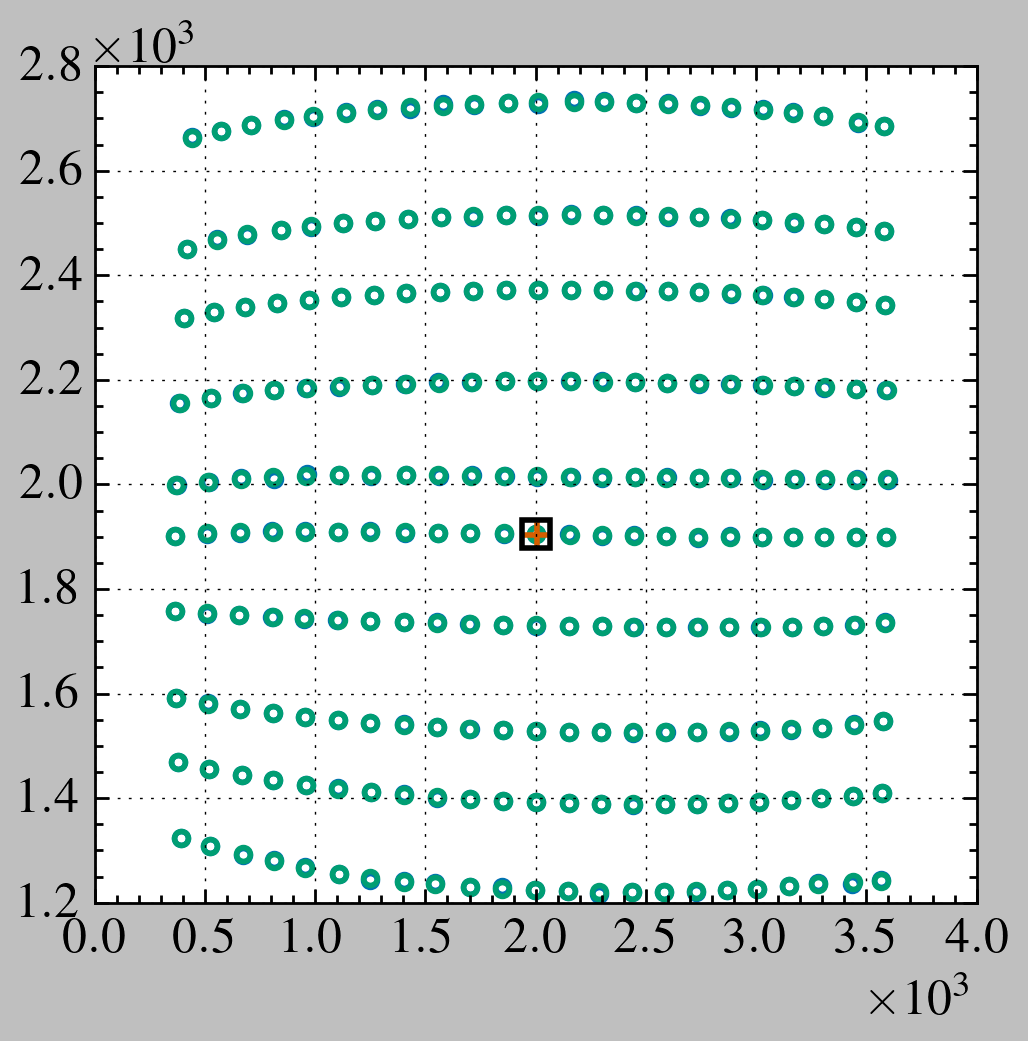

In [300]:
plt.figure(figsize = (15, 10))
plt.subplot(231)
plt.plot(300+peakPosition[:, 1], 550+peakPosition[:, 0], '.')

plt.plot(original_grid_X_evt1_new, original_grid_Y_evt1_new, '.')

plt.plot(centre_distortion_X, centre_distortion_Y, '+')
plt.plot(X_mesh[idx_centreDistortion_row, idx_centreDistortion_column], Y_mesh[idx_centreDistortion_row, idx_centreDistortion_column], 's')
plt.tight_layout()
plt.show()

## Construct cartesian grid

In [350]:
dt = X_mesh[idx_centreDistortion_row, idx_centreDistortion_column + 1] - X_mesh[idx_centreDistortion_row, idx_centreDistortion_column]

dx = Y_mesh[idx_centreDistortion_row, idx_centreDistortion_column] - Y_mesh[idx_centreDistortion_row-1, idx_centreDistortion_column]
print(dt, dx)

152 176


In [367]:
t_true = (np.arange(0, X_mesh.shape[1], 1, dtype = np.float64) - idx_centreDistortion_column)*dt + centre_distortion_X


x_true = (np.arange(0, X_mesh.shape[0], 1, dtype = np.float64) - idx_centreDistortion_row)*dx + centre_distortion_Y

t_cartesian, x_cartesian = np.meshgrid(t_true, x_true)
t_cartesian_flat, x_cartesian_flat = t_cartesian.T.flatten(), x_cartesian.T.flatten()

In [352]:
X_mesh.shape[1], idx_centreDistortion_column

(23, 11)

In [365]:
t_cartesian.shape, x_cartesian.shape

((10, 23), (10, 23))

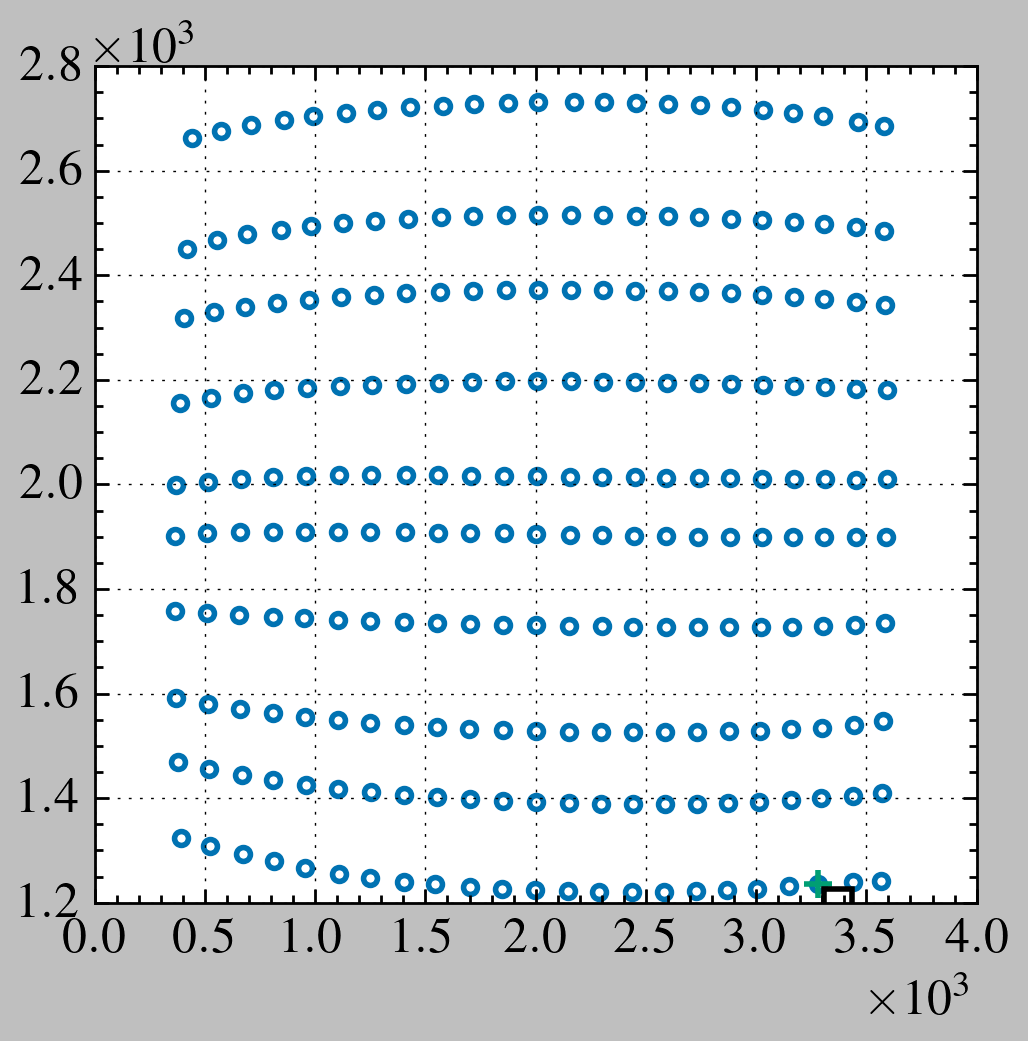

In [370]:
plt.figure(figsize = (15, 10))
plt.subplot(231)
# plt.plot(300+peakPosition[:, 1], 550+peakPosition[:, 0], '.')

plt.plot(original_grid_X_evt1_new, original_grid_Y_evt1_new, '.')

# plt.plot(centre_distortion_X, centre_distortion_Y, '+')
# plt.plot(X_mesh[idx_centreDistortion_row, idx_centreDistortion_column], Y_mesh[idx_centreDistortion_row, idx_centreDistortion_column], 's')

# plt.plot(t_cartesian_flat[:], x_cartesian_flat[:], 's')

idxRow = 0
idxColumn = 10

idx = 200
plt.plot(original_grid_X_evt1_new[idx], original_grid_Y_evt1_new[idx], '+')

# plt.plot(t_cartesian[idxRow, idxColumn], x_cartesian[idxRow, idxColumn], 's')
plt.plot(t_cartesian_flat[idx], x_cartesian_flat[idx], 's')

plt.tight_layout()
plt.show()

In [371]:

user_grid = [(i, j) for (i, j) in zip(original_grid_Y_evt1_new, original_grid_X_evt1_new)]
output_grid = [(i, j) for (i, j) in zip(x_cartesian_flat, t_cartesian_flat)]



In [377]:

user_grid_ToSave = [(i, j) for (i, j) in zip(original_grid_Y_evt1_new, original_grid_X_evt1_new)]
output_grid_ToSave = [(i, j) for (i, j) in zip(x_cartesian_flat, t_cartesian_flat)]

calibrationFileToSave = np.hstack((user_grid_ToSave, output_grid_ToSave))

np.savetxt('./VISAR_KEPLER2_10nsWindow_900499_run78_polynomial_16042025.cal', calibrationFileToSave, delimiter=',')

In [373]:
start_time = time.time()

# load grid coordinates from file
grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
grid_z = griddata(
    output_grid, user_grid, (grid_1, grid_2), method="cubic"
)  # used to visualize the coordinates on image
map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
map_1_32 = map_1.astype("float32")
map_2_32 = map_2.astype("float32")


warped = cv2.remap(
    img, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
)



print("\n--- %s seconds ---" % (time.time() - start_time))  # end single run timer


--- 4.624221086502075 seconds ---


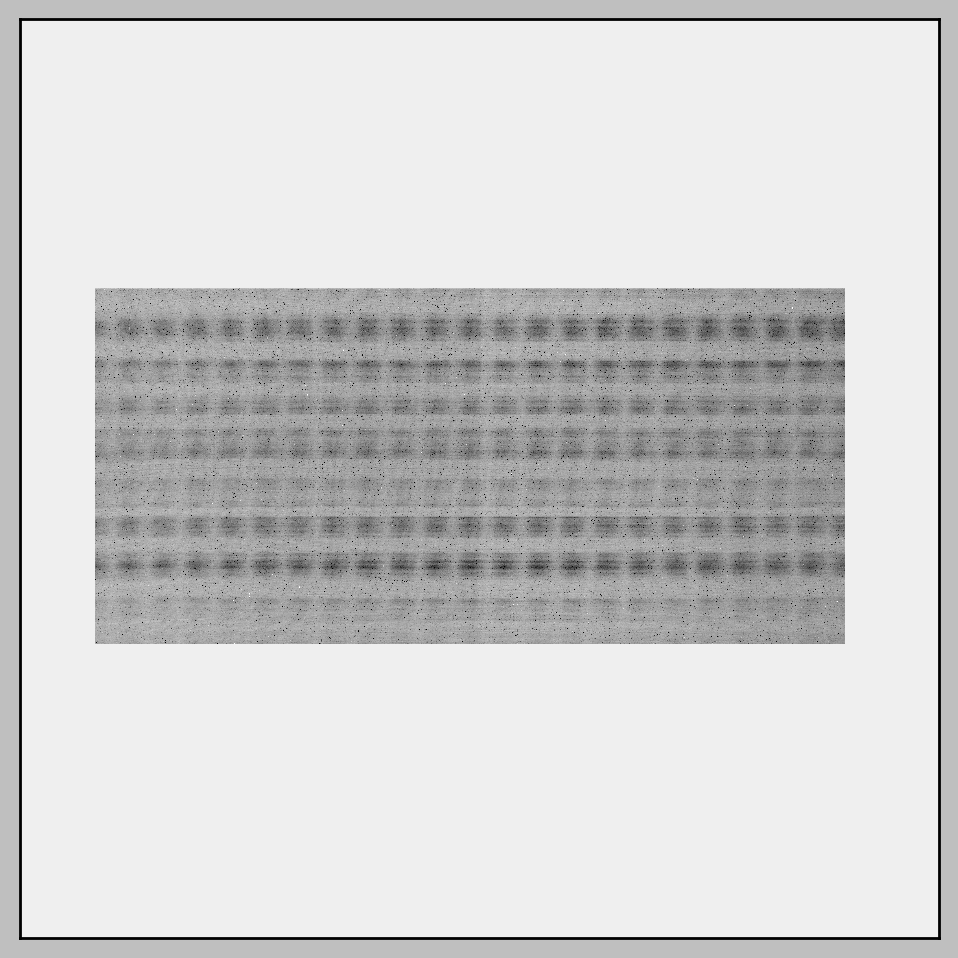

In [375]:
# Setup plot
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(warped, cmap="binary", vmin=100, vmax=200)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.savefig('../DewarpedIm_r1222_V2.png', dpi = 500)
plt.show()